Running on CPU/GPU
Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1590s 1s/step - accuracy: 0.5826 - loss: 0.7225 - val_accuracy: 0.5853 - val_loss: 0.7028 - learning_rate: 0.0100
Epoch 2/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 769s 699ms/step - accuracy: 0.7567 - loss: 0.5187 - val_accuracy: 0.7829 - val_loss: 0.4821 - learning_rate: 0.0100
Epoch 3/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 766s 696ms/step - accuracy: 0.8659 - loss: 0.3347 - val_accuracy: 0.7376 - val_loss: 0.7444 - learning_rate: 0.0100
Epoch 4/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 731s 664ms/step - accuracy: 0.8866 - loss: 0.2940 - val_accuracy: 0.8112 - val_loss: 0.4485 - learning_rate: 0.0100
Epoch 5/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 748s 680ms/step - accuracy: 0.8943 - loss: 0.2746 - val_accuracy: 0.8669 - val_loss: 0.2916 - learning_rate: 0.0100
Epoch 6/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 749s 680ms/step - accuracy: 0.9014 - loss: 0.2621 - val_accuracy: 0.7801 - val_loss: 0.6023 - learning_rate: 0.0100
Epoch 7/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 751s 683ms/step - accur

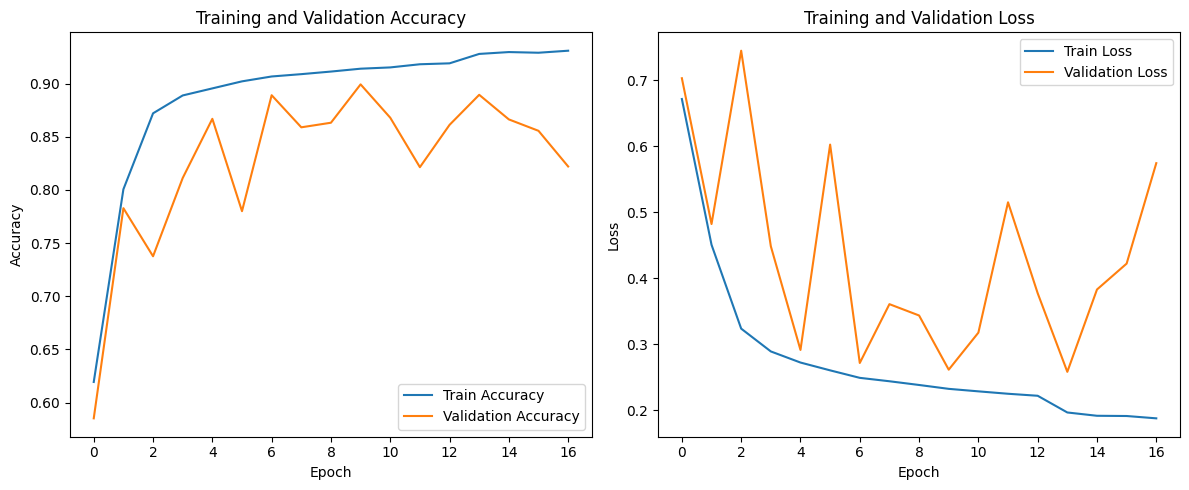

86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      5492
           1       0.87      0.77      0.82      5413

    accuracy                           0.83     10905
   macro avg       0.83      0.83      0.83     10905
weighted avg       0.83      0.83      0.83     10905

Confusion Matrix:
[[4840  652]
 [1221 4192]]


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Enable TPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU/GPU")

# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define dataset paths
dataset_path = '/kaggle/input/deepfake-and-real-images/Dataset'
train_dir = os.path.join(dataset_path, 'Train')
val_dir = os.path.join(dataset_path, 'Validation')
test_dir = os.path.join(dataset_path, 'Test')

# Hyperparameters
img_size = (128, 128)
batch_size = 128
epochs = 30  # Increased to allow early stopping to work effectively
learning_rate = 0.01

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model architecture
with strategy.scope():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.5),  # Increased dropout for better regularization
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.005,  # Minimum accuracy improvement threshold (0.5%)
    patience=7,       # Wait for 7 epochs before stopping
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Training with enhanced callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluation
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')

# Save model
model.save("deepfake_model.h5")
model.save("deepfake_model.keras")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Performance metrics
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
print('Classification Report:')
print(classification_report(y_true, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))

In [2]:
model.save("DeepfakeDetection.h5")
model.save("DeepfakeDetection.keras")